## Classifying young stellar objects in molecular clouds using *Tree*-based algorithms
## Decision Tree and Random Forest

In [10]:
#All the imports
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read the YSO classification file for YSOs from Gutermuth et al. 2009 (G09)
# Table 4 in G09, full data available online
# I have downloaded a TSV file from VizieR, and replaced blanks by NaNs before using here.

df_yso = pd.read_csv("table4_Gutermuth09.csv", comment='#', header=0)

print(df_yso.shape)
df_yso.head()


(2548, 11)


,Jmag,Hmag,Ksmag,3.6mag,4.5mag,5.8mag,8.0mag,24mag,AKs,alpha,Cl
0,15.1,14.3,13.92,13.27,NaN,12.34,NaN,6.82,0.10,NaN,I*
1,NaN,NaN,13.84,11.34,10.05,8.99,8.10,4.34,NaN,0.87,I
2,NaN,NaN,14.98,11.90,10.76,9.96,9.28,NaN,NaN,0.12,I
3,NaN,15.0,12.86,10.52,9.61,8.84,7.97,NaN,1.92,0.08,I
4,NaN,NaN,NaN,14.22,13.20,12.09,11.36,NaN,NaN,0.48,I


In [4]:
# Get information of the dataframe
df_yso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2548 entries, 0 to 2547
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Jmag    1675 non-null   float64
 1   Hmag    1970 non-null   float64
 2   Ksmag   2132 non-null   float64
 3   3.6mag  2523 non-null   float64
 4   4.5mag  2522 non-null   float64
 5   5.8mag  2381 non-null   float64
 6   8.0mag  2203 non-null   float64
 7   24mag   1274 non-null   float64
 8   AKs     1937 non-null   float64
 9   alpha   2171 non-null   float64
 10  Cl      2548 non-null   object 
dtypes: float64(10), object(1)
memory usage: 219.1+ KB


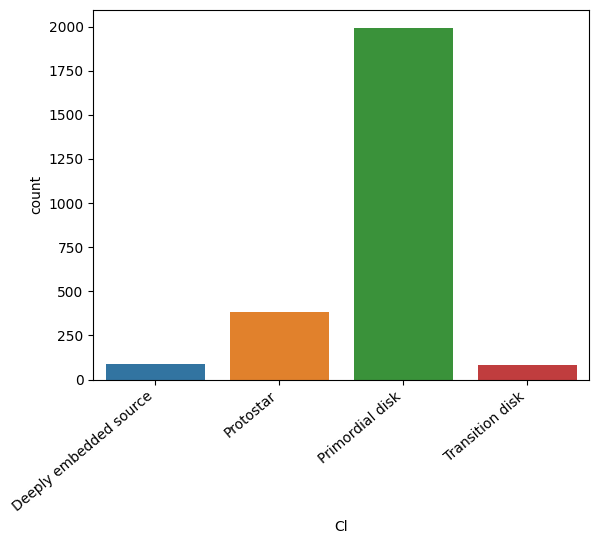

In [6]:
# Visualize different YSO classes
ax = sns.countplot(x = df_yso['Cl'])
ax.set_xticklabels(["Deeply embedded source", "Protostar", "Primordial disk", "Transition disk",], rotation=40, ha="right")
plt.tight_layout
plt.show()

In [7]:
# Create a binary classification of YSO: class 0 and 1 represented by class 1; and class 2 and 3 represented by class 2
df_yso.loc[((df_yso["Cl"] == 'I*') | (df_yso["Cl"] == 'I')), "YSO"] = "I"
df_yso.loc[((df_yso["Cl"] == 'II*') | (df_yso["Cl"] == 'II')), "YSO"] = "II"


In [8]:
# Check the new column
df_yso.head()

,Jmag,Hmag,Ksmag,3.6mag,4.5mag,5.8mag,8.0mag,24mag,AKs,alpha,Cl,YSO
0,15.1,14.3,13.92,13.27,NaN,12.34,NaN,6.82,0.10,NaN,I*,I
1,NaN,NaN,13.84,11.34,10.05,8.99,8.10,4.34,NaN,0.87,I,I
2,NaN,NaN,14.98,11.90,10.76,9.96,9.28,NaN,NaN,0.12,I,I
3,NaN,15.0,12.86,10.52,9.61,8.84,7.97,NaN,1.92,0.08,I,I
4,NaN,NaN,NaN,14.22,13.20,12.09,11.36,NaN,NaN,0.48,I,I


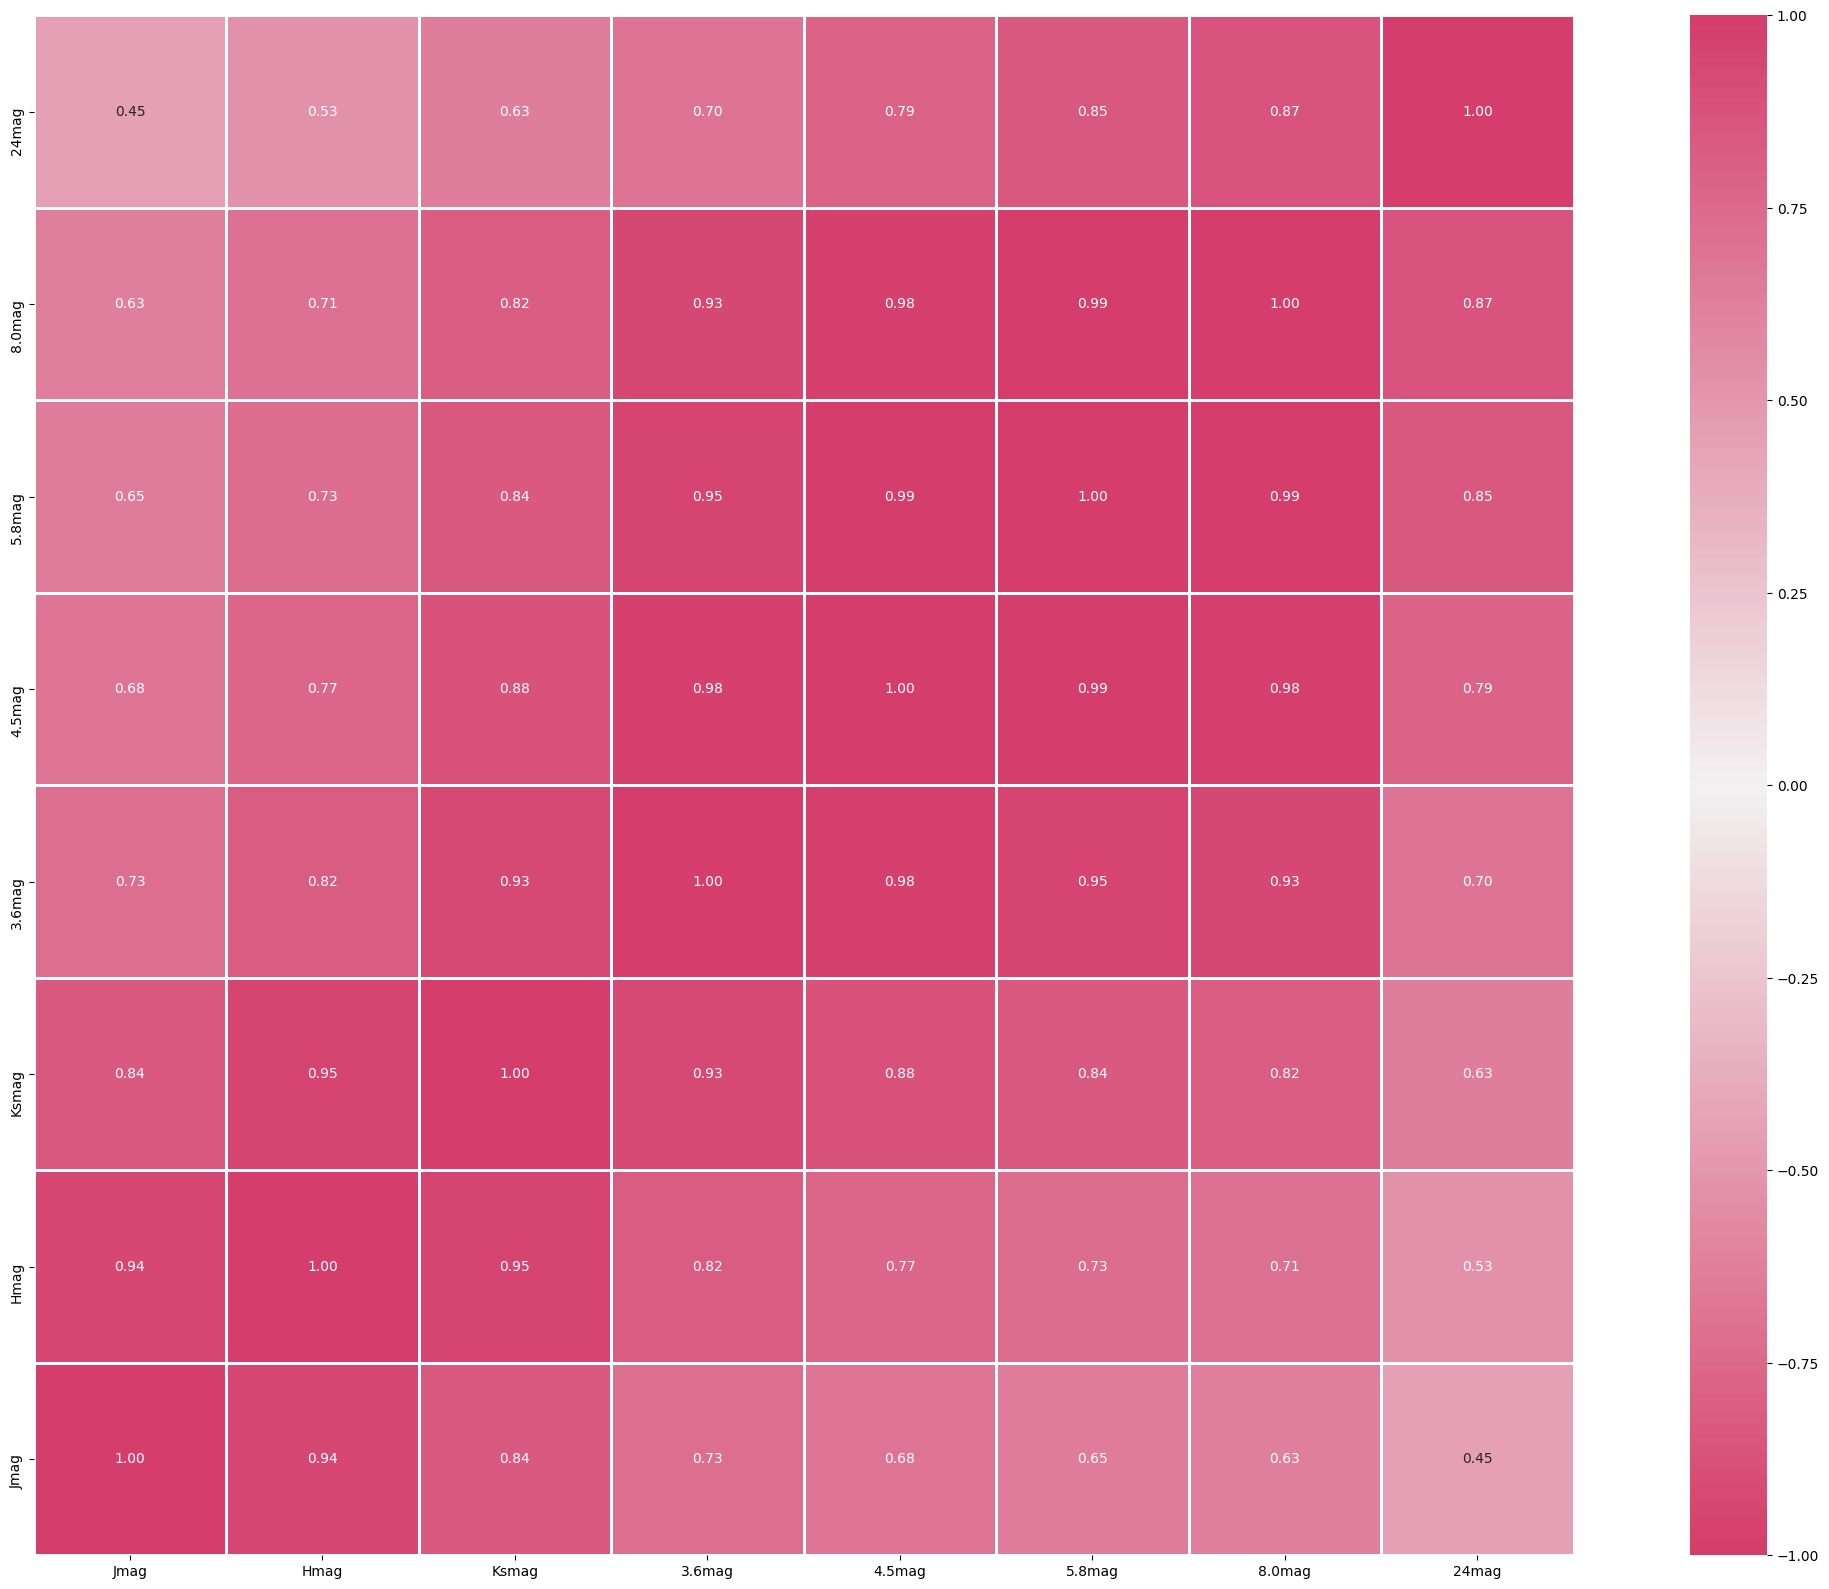

In [12]:
#Create a correlation matrix of variables
corr = df_yso[["Jmag", "Hmag", "Ksmag", "3.6mag", "4.5mag", "5.8mag", "8.0mag", "24mag", "YSO"]].corr()

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30,20))

#Set up custom diverging color map
cmap = sns.diverging_palette(-359, 359, as_cmap=True)

#Draw the heatmap with the mask and the correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0,
           square=True, annot=True, fmt='.2f', linewidths=1)
ax.invert_yaxis()
plt.show()

In [13]:
# Nice correlations in adjacent bands. Now filter data.

#### Lots of NaN values.  Various ways to deal with NaN values- i) exclude them all, ii) Impute with values (constant, mean, median, etc), iii) "smart" imputing by using a trained model to guess missing values
#### First I train a model simply by excluding NaNs. Later I impute NaN values with trained random forest models.

In [14]:
# Drop the dataset containing NaN values
df_yso1 = df_yso.copy()
df_yso1.dropna(inplace=True)

In [15]:
df_yso1.head()

,Jmag,Hmag,Ksmag,3.6mag,4.5mag,5.8mag,8.0mag,24mag,AKs,alpha,Cl,YSO
8,13.59,12.48,12.05,11.96,11.03,10.09,9.02,5.41,0.53,0.54,I,I
10,16.16,14.00,12.56,10.33,9.41,8.58,7.67,4.13,1.27,0.21,I,I
13,13.18,11.59,10.68,9.62,9.26,8.93,8.47,6.27,0.86,-1.53,II,II
15,14.95,13.76,13.03,12.01,11.44,10.87,9.98,6.64,0.38,-0.51,II,II
19,13.07,11.91,11.22,10.29,9.85,9.46,8.89,6.47,0.39,-1.24,II,II


In [16]:
# check if there is any NaN value in new dataset
df_yso1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822 entries, 8 to 2547
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Jmag    822 non-null    float64
 1   Hmag    822 non-null    float64
 2   Ksmag   822 non-null    float64
 3   3.6mag  822 non-null    float64
 4   4.5mag  822 non-null    float64
 5   5.8mag  822 non-null    float64
 6   8.0mag  822 non-null    float64
 7   24mag   822 non-null    float64
 8   AKs     822 non-null    float64
 9   alpha   822 non-null    float64
 10  Cl      822 non-null    object 
 11  YSO     822 non-null    object 
dtypes: float64(10), object(2)
memory usage: 83.5+ KB


### First I implement a simple Decision Tree based on the CART algorithm. Later I use Random Forest.

In [17]:
# Make features and target to make Decision Tree with CART
flux_cols = ["Jmag", "Hmag", "Ksmag", "3.6mag", "4.5mag", "5.8mag", "8.0mag", "24mag"]
features = df_yso1[flux_cols]
target = df_yso1["YSO"]

In [18]:
# split train-test 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3) # 70% training and 30% test

In [19]:
# To avoid over-fitting, set certain parameters
# one way to select min_sample_leaf = some percent (1%) of training set; and minimum Gini impurity = 1%
minImpurity = 0.5*0.01      # 1% of maximum
minSample = int(X_train.shape[0]*0.01)      # 1% of training data
print(minImpurity, minSample)

0.005 5


In [20]:
# Use decision tree to find feature importance
clf = DecisionTreeClassifier(min_impurity_split=minImpurity, min_samples_leaf = minSample)
clf =clf.fit(X_train, y_train)
imp_prob = clf.feature_importances_
print(imp_prob, sum(imp_prob))

[0.0246153  0.38005815 0.13159321 0.04210846 0.         0.
 0.         0.42162488] 0.9999999999999999


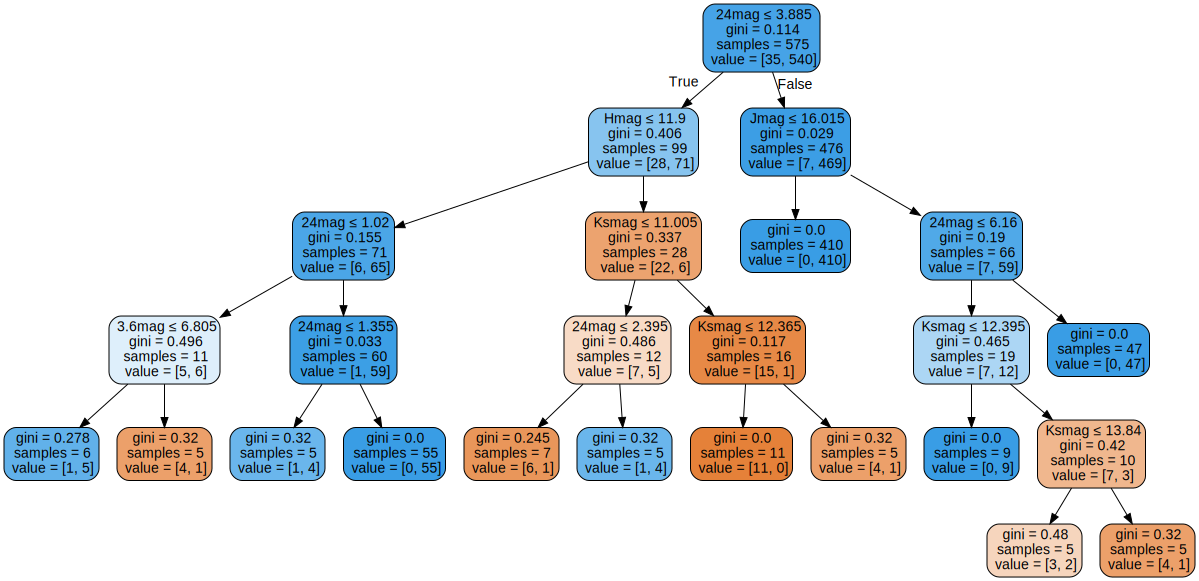

In [21]:
# visualize the tree
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(clf, out_file=None,
                               feature_names = features.columns,
                                filled=True, rounded=True,
                                special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("tree")
graph

In [22]:
y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9554655870445344


### Pretty good! However, a single decision tree may be intrinsically flawed and give different results in different runs. So need to create many such trees and develop a methodology to select the best outcomes.  
### Enter Random Forest 

In [23]:
#Create a Gaussian Classifier
clf_rf =RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets 
clf_rf.fit(X_train,y_train)

#Predict using random forest classifier
y_pred_rf = clf_rf.predict(X_test)

#Feature importance prediction using random forest
imp_rf = clf_rf.feature_importances_
print("Feature importance", imp_rf)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))

Feature importance [0.11336515 0.13348385 0.13599056 0.12843391 0.08612685 0.09210846
 0.11184273 0.19864847]
Accuracy: 0.9554655870445344


#### Not any major change in accuracy. This means Decision Tree is already doing a decent job.

### Use the same model that is trained in G09 data to predict accuracy in Mon R2 cloud

In [25]:
# Data for Mon R2 is obtained by direct communication with Rob Gutermuth
df_yso_monr2 = pd.read_csv("cg_table_monr2.txt", delim_whitespace = True, header = 1)
print(df_yso_monr2.shape)
df_yso_monr2.head()

(345580, 21)


,index,ra,dec,j,h,k,ch1,ch2,ch3,ch4,...,uj,uh,uk,uch1,uch2,uch3,uch4,um24,ak,class
0,0,91.444698,-7.600098,-100.000,-100.000,-100.00,-100.0,9.89795,-100.0,-100.0,...,10.000,10.000,10.000,10.0,0.001404,10.0,10.0,10.0,0.0,-100
1,1,91.997838,-7.598932,15.717,15.246,14.94,-100.0,14.70790,-100.0,-100.0,...,0.052,0.057,0.121,10.0,0.033544,10.0,10.0,10.0,0.0,-100
2,2,91.677009,-7.599051,-100.000,-100.000,-100.00,-100.0,16.62410,-100.0,-100.0,...,10.000,10.000,10.000,10.0,0.133982,10.0,10.0,10.0,0.0,-100
3,3,91.279461,-7.598841,16.495,15.674,-100.00,-100.0,15.31380,-100.0,-100.0,...,0.118,0.118,10.000,10.0,0.056569,10.0,10.0,10.0,0.0,-100
4,4,91.758295,-7.597690,-100.000,-100.000,-100.00,-100.0,16.67360,-100.0,-100.0,...,10.000,10.000,10.000,10.0,0.119299,10.0,10.0,10.0,0.0,-100


In [26]:
# This dataset contains sources that are not only protostars and YSOs, but also other contaminants which we have to filter
# Ignore unclassified objects and anything that's not protostars and ysos
df_yso_monr2 = df_yso_monr2[(df_yso_monr2['class'] < 3) & (df_yso_monr2['class'] > 0)]
print(df_yso_monr2.shape)
df_yso_monr2.head()

(884, 21)


,index,ra,dec,j,h,k,ch1,ch2,ch3,ch4,...,uj,uh,uk,uch1,uch2,uch3,uch4,um24,ak,class
1267,1267,90.948061,-7.557119,14.669,13.421,12.896,12.3790,12.1857,11.84740,11.06900,...,0.032,0.030,0.030,0.004564,0.004776,0.016475,0.021548,10.0,0.671157,2
2788,2788,91.403461,-7.518582,14.732,13.913,13.624,13.3014,12.9536,12.90750,11.86960,...,0.030,0.035,0.037,0.005826,0.007166,0.033384,0.026498,10.0,0.208209,2
3129,3129,90.991433,-7.510770,17.124,15.731,15.133,13.5590,12.7695,11.94880,10.74760,...,0.201,0.145,0.143,0.006614,0.006442,0.014004,0.010283,10.0,0.000000,1
3136,3136,91.362595,-7.510635,13.462,12.687,12.314,10.8422,9.9687,9.66104,8.36233,...,0.042,0.053,0.040,0.003073,0.002400,0.003850,0.002621,10.0,0.061267,2
3566,3566,90.997559,-7.500339,-100.000,-100.000,-100.000,14.0109,13.0553,12.20090,11.15550,...,10.000,10.000,10.000,0.009398,0.007185,0.019390,0.021280,10.0,0.000000,1


In [27]:
df_yso_monr2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884 entries, 1267 to 210352
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   884 non-null    int64  
 1   ra      884 non-null    float64
 2   dec     884 non-null    float64
 3   j       884 non-null    float64
 4   h       884 non-null    float64
 5   k       884 non-null    float64
 6   ch1     884 non-null    float64
 7   ch2     884 non-null    float64
 8   ch3     884 non-null    float64
 9   ch4     884 non-null    float64
 10  m24     884 non-null    float64
 11  uj      884 non-null    float64
 12  uh      884 non-null    float64
 13  uk      884 non-null    float64
 14  uch1    884 non-null    float64
 15  uch2    884 non-null    float64
 16  uch3    884 non-null    float64
 17  uch4    884 non-null    float64
 18  um24    884 non-null    float64
 19  ak      884 non-null    float64
 20  class   884 non-null    int64  
dtypes: float64(19), int64(2)
memory u

In [28]:
# A value of -100 in fluxes and 10 in uncertainties are missing values. Replace them with NANs
#Replace the -100 values in flux variables as nan
flux_cols = ["j", "h", "k", "ch1", "ch2", "ch3", "ch4", "m24"]
for col in flux_cols:
    df_yso_monr2.loc[df_yso_monr2[col] == -100, col] = np.nan

#Replace the 10 values in uncertainty variables as nan
uncertainty_cols = ["uj", "uh", "uk", "uch1", "uch2", "uch3", "uch4", "um24"]
for col in uncertainty_cols:
    df_yso_monr2.loc[df_yso_monr2[col] == 10, col] = np.nan

In [29]:
# Create a binary classification of YSO: class 0 and 1 represented by class 1; and class 2 and 3 represented by class 2
df_yso_monr2.loc[df_yso_monr2["class"] <= 1, "YSO"] = "I"
df_yso_monr2.loc[df_yso_monr2["class"] >= 2, "YSO"] = "II"

# check if the missing values are NaN, and newly added column
df_yso_monr2.head()

,index,ra,dec,j,h,k,ch1,ch2,ch3,ch4,...,uh,uk,uch1,uch2,uch3,uch4,um24,ak,class,YSO
1267,1267,90.948061,-7.557119,14.669,13.421,12.896,12.3790,12.1857,11.84740,11.06900,...,0.030,0.030,0.004564,0.004776,0.016475,0.021548,NaN,0.671157,2,II
2788,2788,91.403461,-7.518582,14.732,13.913,13.624,13.3014,12.9536,12.90750,11.86960,...,0.035,0.037,0.005826,0.007166,0.033384,0.026498,NaN,0.208209,2,II
3129,3129,90.991433,-7.510770,17.124,15.731,15.133,13.5590,12.7695,11.94880,10.74760,...,0.145,0.143,0.006614,0.006442,0.014004,0.010283,NaN,0.000000,1,I
3136,3136,91.362595,-7.510635,13.462,12.687,12.314,10.8422,9.9687,9.66104,8.36233,...,0.053,0.040,0.003073,0.002400,0.003850,0.002621,NaN,0.061267,2,II
3566,3566,90.997559,-7.500339,NaN,NaN,NaN,14.0109,13.0553,12.20090,11.15550,...,NaN,NaN,0.009398,0.007185,0.019390,0.021280,NaN,0.000000,1,I


In [30]:
# Drop the dataset containing NaN values
df_yso1_monr2 = df_yso_monr2.copy()
df_yso1_monr2.dropna(inplace=True)

df_yso1_monr2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 16385 to 210352
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   355 non-null    int64  
 1   ra      355 non-null    float64
 2   dec     355 non-null    float64
 3   j       355 non-null    float64
 4   h       355 non-null    float64
 5   k       355 non-null    float64
 6   ch1     355 non-null    float64
 7   ch2     355 non-null    float64
 8   ch3     355 non-null    float64
 9   ch4     355 non-null    float64
 10  m24     355 non-null    float64
 11  uj      355 non-null    float64
 12  uh      355 non-null    float64
 13  uk      355 non-null    float64
 14  uch1    355 non-null    float64
 15  uch2    355 non-null    float64
 16  uch3    355 non-null    float64
 17  uch4    355 non-null    float64
 18  um24    355 non-null    float64
 19  ak      355 non-null    float64
 20  class   355 non-null    int64  
 21  YSO     355 non-null    object 


#### The aim is to use the model that is trained in G09 data to classify the YSOs in Mon R2

In [32]:
# Make features and target for Mon R2
features_monr2 = df_yso1_monr2[flux_cols]
target_monr2 = df_yso1_monr2["YSO"]

#Predict outcome using random forest classifier made from the G09 sources
y_pred_rf_monr2 = clf_rf.predict(features_monr2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(target_monr2, y_pred_rf_monr2))

Accuracy: 0.9464788732394366


#### So I used a model that is trained with different sources, and used it to classify sources in Mon R2 with ~95% accuracy. This is NEAT!
#### Similarly I used the model to classify sources in Cep OB3 and got accuracy of ~96%.
### In astrophysics we can't run away from missing data problem. Filtering out NaN values is not the "optimal" way to deal with it. Next, we will see in _ysoClass__impute__test.ipynb_ how to use a generalized learned model to impute missing values.